# Code for fig 4. From Jake's csv files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

plt.rcParams.update({'font.size': 18})

In [2]:
data = pd.read_csv("Data/moments_method_kde_manual.csv")

In [3]:
data.head()

,city_pops,mean,variance,skewness,kurtosis
0,102471,49662.902967,2.090648e+08,7.986730e+11,1.349811e+17
1,182130,46390.425872,2.196585e+08,6.554460e+11,1.353712e+17
2,139949,48341.191479,1.361017e+08,8.536681e+10,5.318711e+16
3,848742,57152.855491,7.397489e+08,1.983952e+13,2.828707e+18
4,110863,42632.783624,1.880214e+08,1.278399e+11,9.827861e+16


In [4]:
len(data)

544

In [5]:
# remove 0 and negative values
data2 = data[(data > 0).all(1)]

In [6]:
len(data2)

511

In [7]:
# compute log of values
data2["logPop"] = np.log10(data2.city_pops)
data2["logMean"] = np.log10(data2["mean"])
data2["logVar"] = np.log10(data2.variance)
data2["logSkewness"] = np.log10(data2.skewness)
data2["logKurtosis"] = np.log10(data2["kurtosis"])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A val

In [18]:
def binData(data2, nbins):
    """
    Bin data by quantiles. 
    """
    data2["popBin"] = pd.qcut(data2.logPop, q = nbins)    
    
    out = data2.groupby('popBin')['logPop', "logMean", "logVar", "logSkewness", "logKurtosis"].agg('mean')

    return out


binned = binData(data2, 20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [19]:
binned.head()

,logPop,logMean,logVar,logSkewness,logKurtosis
popBin,,,,,
"(5.0, 5.027]",5.015582,4.657944,8.100984,11.473500,16.718305
"(5.027, 5.054]",5.040746,4.691420,8.235596,11.604747,16.983185
"(5.054, 5.089]",5.071559,4.675470,8.241133,11.741960,17.007738
"(5.089, 5.116]",5.103551,4.677241,8.240694,11.635442,16.978291
"(5.116, 5.154]",5.138733,4.671786,8.222200,11.636015,16.950912


In [20]:
def scalingCI(df, xvar, yvar):
    # get scaling summary for one column. 
    # mean scaling exponent and 95% CI upper and lower bound

    X = df[xvar]
    y = df[yvar]
                
                
    X = sm.add_constant(X)
    res = sm.OLS(y,X ,missing = 'drop').fit()
                
    CI = 0.05 # 1 - confidence interval 
    out= {"beta": res.params[1], 
            "beta_l": res.conf_int(CI) [0][1], 
                 "beta_u": res.conf_int(CI) [1][1], 
                 "b": res.params[0], 
                  "b_l": res.conf_int(CI) [0][0], 
                  "b_u": res.conf_int(CI) [1][0]
                 }

    return out

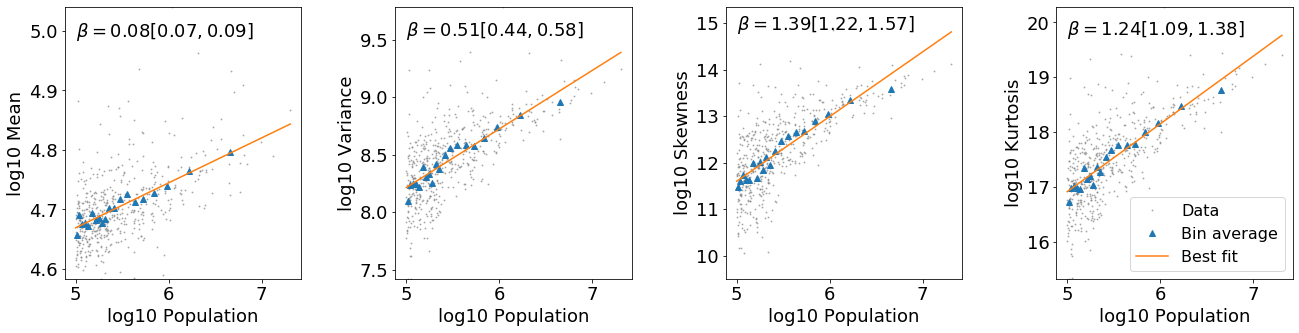

In [24]:
# plot the scaling results
def plot_panel(binned, data, xvar, yvar, offset = 0, ymin = 0, ymax = 0): 
    """
    binned: summary of binned data
    data: raw data
    xbin, ybin: names of binned variable
    xvar, yvar: names of raw variable
    """
    
    plt.plot(data[xvar], data[yvar], ".", alpha = 0.5, color = "grey", markersize = 2)
    plt.plot(binned[xvar], binned[yvar], "^")
    
    out = scalingCI(binned, xvar, yvar)
    
    #beta, b = np.polyfit(binned[xvar], binned[yvar], 1)
    
    x = np.linspace(data[xvar].min(),  data[xvar].max(), 10)
    

    plt.plot(x, x*out["beta"] + out["b"], "-")
    text = r"$\beta = {:.2f} [{:.2f}, {:.2f}]$".format(out["beta"], out["beta_l"], out["beta_u"])
    
    plt.text(data[xvar].min(), offset+data[yvar].max(), text)
    
    plt.ylim([data[yvar].min()+ ymin, data[yvar].max()+ ymax])

plt.figure(figsize = (22, 5))

plt.subplot(1, 4, 1)
o1 = plot_panel(binned, data2, "logPop", "logMean",   offset = -0.05, ymin = 0, ymax = 0)
plt.xlabel("log10 Population")
plt.ylabel("log10 Mean")


plt.subplot(1, 4, 2)
o1 = plot_panel(binned, data2, "logPop", "logVar",   offset = -0.25, ymin = 0, ymax = 0)
plt.xlabel("log10 Population")
plt.ylabel("log10 Variance")


plt.subplot(1, 4, 3)
o1 = plot_panel(binned, data2, "logPop", "logSkewness",   offset = 0, ymin = 1.5, ymax = 0.5)
plt.xlabel("log10 Population")
plt.ylabel("log10 Skewness")

plt.subplot(1, 4, 4)
o1 = plot_panel(binned, data2, "logPop", "logKurtosis",   offset = -0.5, ymin = 0, ymax = 0)
plt.xlabel("log10 Population")
plt.ylabel("log10 Kurtosis")

plt.legend(["Data", "Bin average", "Best fit"], loc = 4, fontsize = 16)


#plt.subplots_adjust(wspace = 0.4, hspace = 0.3)
plt.subplots_adjust(wspace = 0.4)



In [22]:
len(binned)

20